/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,088 (930.03 KB)

 Trainable params: 238,088 (930.03 KB)

 Non-trainable params: 0 (0.00 B)

RNN: Average Accuracy = 0.91
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


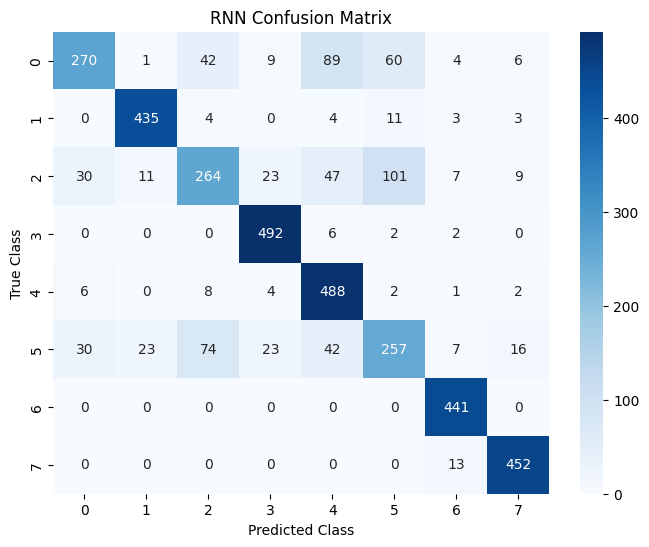

RNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.56      0.66       481
           1       0.93      0.95      0.94       460
           2       0.67      0.54      0.60       492
           3       0.89      0.98      0.93       502
           4       0.72      0.95      0.82       511
           5       0.59      0.54      0.57       472
           6       0.92      1.00      0.96       441
           7       0.93      0.97      0.95       465

    accuracy                           0.81      3824
   macro avg       0.81      0.81      0.80      3824
weighted avg       0.81      0.81      0.80      3824



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('R2_ChatGPt_dataset1.csv', encoding='latin1')

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply text cleaning
df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

# Prepare labels
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
df = df[df['ChatGPT_Annotations'].isin(y_dict.keys())]
y = df['ChatGPT_Annotations'].map(y_dict).values
num_classes = len(y_dict)
y = to_categorical(y, num_classes=num_classes)

# Tokenize and pad sequences
max_features = 2000
maxlen = 100
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Base_Reviews'].values)
X = tokenizer.texts_to_sequences(df['Base_Reviews'].values)
X = pad_sequences(X, maxlen=maxlen)

# Oversampling to balance the dataset
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# RNN Model definition
rnn_model = keras.models.Sequential([
    keras.layers.Embedding(max_features, 100, input_length=maxlen),
    keras.layers.SimpleRNN(128, dropout=0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])
rnn_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Build the model to see the summary before training
rnn_model.build(input_shape=(None, maxlen))
rnn_model.summary()

# K-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
rnn_acc_scores = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    rnn_loss, rnn_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
    rnn_acc_scores.append(rnn_acc)

# Output average accuracy
avg_rnn_acc = np.mean(rnn_acc_scores)
print("RNN: Average Accuracy = {:.2f}".format(avg_rnn_acc))

# Confusion matrix and classification report
y_pred = rnn_model.predict(X_test)
rnn_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

rnn_cm = confusion_matrix(y_true, rnn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

rnn_report = classification_report(y_true, rnn_pred)
print("RNN Classification Report:")
print(rnn_report)
